# Tutorial: Ingest and query data from Apache Kafka

This tutorial introduces you to streaming ingestion in Apache Druid using the Apache Kafka event streaming platform.
Follow along to learn how to create and load data into a Kafka topic, start ingesting data from the topic into Druid, and query results over time. This tutorial assumes you have a basic understanding of Druid ingestion, querying, and API requests.

## Table of contents

* [Prerequisites](#Prerequisites)
* [Run the Docker application](#Run-the-Docker-application)
* [Create Kafka topic](#Create-Kafka-topic)
* [Load data into Kafka topic](#Load-data-into-Kafka-topic)
* [Start Druid ingestion](#Start-Druid-ingestion)
* [Query Druid datasource and visualize query results](#Query-Druid-datasource-and-visualize-query-results)
* [Learn more](#Learn-more)

## Prerequisites

This Docker-based tutorial for Kafka requires that you have **Docker** and **Docker Compose** to start and run the tutorial.

## Run the Docker application

The Docker application launches containers for Druid services, Kafka, and Jupyter.
It includes this tutorial as well as other [Jupyter notebook tutorials for Druid](https://druid.apache.org/docs/latest/tutorials/tutorial-jupyter-index.html).

Run the Docker application as follows:

1. Clone the [apache/druid repo](https://github.com/apache/druid) and navigate to `druid/examples/quickstart/jupyter-notebooks/docker-jupyter`. Alternatively, you can download a local copy of [`docker-compose.yaml`](https://github.com/apache/druid/blob/master/examples/quickstart/jupyter-notebooks/docker/docker-compose.yaml) and [`environment`](https://github.com/apache/druid/blob/master/examples/quickstart/jupyter-notebooks/docker/environment).


2. In the same directory as `docker-compose.yaml` and `environment`, start the application:
```
docker-compose --profile all-services up -d
```

3. Navigate to the tutorial at http://localhost:8889/notebooks/kafka-tutorial.ipynb.


4. From the navigation menu, select **File > Save as...**. In the **Save As** dialog, enter `work/kafka-tutorial.ipynb`. This step allows you to retain a local copy of your work in the notebook. If the notebook still shows as read only, you may need to refresh the page.

You can now follow along with the tutorial.
When you are finished with the tutorial, shut down the application using the following command:
```
docker-compose down -v
```

## View the Druid web console

To access the Druid web console, go to http://localhost:8888/unified-console.html.
Use the web console to view datasources and ingestion tasks that you create in this tutorial.

## Create Kafka topic

Run the following cell to import requisite Python packages for this tutorial.

In [1]:
import requests
import json

This notebook relies on the Python client for the Apache Kafka. Import the Kafka producer and consumer modules, then create a Kafka client. You use the Kafka producer to create and publish records to a new topic named `social_media`.

In [2]:
from kafka import KafkaProducer
from kafka import KafkaConsumer

# Kafka runs on kafka:9092 in multi-container tutorial application
producer = KafkaProducer(bootstrap_servers='kafka:9092')
topic_name = "social_media"

Create the `social_media` topic and send a sample event:

In [3]:
event = {
    "__time": "2023-01-03T16:40:21.501",
    "username": "willow_bean",
    "post_title": "This title is required",
    "views": 15284,
    "upvotes": 124,
    "comments": 21,
    "edited": "True"
}

producer.send(topic_name, json.dumps(event).encode('utf-8'))

To verify that the Kafka topic stored the event, create a consumer client to read records from the Kafka cluster, and get the next (only) message:

In [4]:
consumer = KafkaConsumer(topic_name, bootstrap_servers=['kafka:9092'], auto_offset_reset='earliest',
     enable_auto_commit=True)

print(next(consumer).value.decode('utf-8'))

{"__time": "2023-01-03T16:40:21.501", "username": "willow_bean", "post_title": "This title is required", "views": 15284, "upvotes": 124, "comments": 21, "edited": "True"}


## Load data into Kafka topic

Instead of manually creating events to send to the Kafka topic, use a data generator to simulate a continuous data stream. This tutorial makes use of [Druid Data Driver](https://github.com/implydata/druid-datagenerator) to simulate a continuous data stream into the `social_media` Kafka topic. To learn more about the Druid Data Driver, see the Druid Summit talk, [Generating Time centric Data for Apache Druid](https://www.youtube.com/watch?v=3zAOeLe3iAo).

In this notebook, you use a background process to continuously load data into the Kafka topic.
This allows you to keep executing commands in this notebook while data is constantly being streamed into the topic.

Run the following cells to load sample data into the `social_media` Kafka topic:

In [5]:
import multiprocessing as mp
import DruidDataDriver

In [6]:
def run_driver():
    DruidDataDriver.simulate("kafka_docker_config.json", None, None, "REAL")
        
mp.set_start_method('fork')
ps = mp.Process(target=run_driver)
ps.start()

## Start Druid ingestion

Now that you have a new Kafka topic and data being streamed into the topic, you ingest the data into Druid by submitting a Kafka ingestion spec.
For more information about Kafka ingestion in Druid, see [Apache Kafka ingestion](https://druid.apache.org/docs/latest/development/extensions-core/kafka-ingestion.html).

Run the following cells to define and submit the Kafka ingestion spec.

In [7]:
kafka_ingestion_spec = "{\"type\": \"kafka\",\"spec\": {\"ioConfig\": {\"type\": \"kafka\",\"consumerProperties\": {\"bootstrap.servers\": \"kafka:9092\"},\"topic\": \"social_media\",\"inputFormat\": {\"type\": \"json\"},\"useEarliestOffset\": true},\"tuningConfig\": {\"type\": \"kafka\"},\"dataSchema\": {\"dataSource\": \"social_media\",\"timestampSpec\": {\"column\": \"__time\",\"format\": \"iso\"},\"dimensionsSpec\": {\"dimensions\": [\"username\",\"post_title\",{\"type\": \"long\",\"name\": \"views\"},{\"type\": \"long\",\"name\": \"upvotes\"},{\"type\": \"long\",\"name\": \"comments\"},\"edited\"]},\"granularitySpec\": {\"queryGranularity\": \"none\",\"rollup\": false,\"segmentGranularity\": \"hour\"}}}}"

In [8]:
print(json.dumps(json.loads(kafka_ingestion_spec), indent=4))

{
    "type": "kafka",
    "spec": {
        "ioConfig": {
            "type": "kafka",
            "consumerProperties": {
                "bootstrap.servers": "kafka:9092"
            },
            "topic": "social_media",
            "inputFormat": {
                "type": "json"
            },
            "useEarliestOffset": true
        },
        "tuningConfig": {
            "type": "kafka"
        },
        "dataSchema": {
            "dataSource": "social_media",
            "timestampSpec": {
                "column": "__time",
                "format": "iso"
            },
            "dimensionsSpec": {
                "dimensions": [
                    "username",
                    "post_title",
                    {
                        "type": "long",
                        "name": "views"
                    },
                    {
                        "type": "long",
                        "name": "upvotes"
                    },
                    {
 

In [9]:
ingestion_endpoint = "http://coordinator:8081/druid/indexer/v1/supervisor"

headers = {
  'Content-Type': 'application/json'
}
response = requests.request("POST", ingestion_endpoint, headers=headers, data=kafka_ingestion_spec)

print(response.text)

{"id":"social_media"}


## Query Druid datasource and visualize query results

You can now query the new datasource called `social_media`. In this section, you also visualize query results using the Matplotlib and Seaborn visualization libraries. Run the following cell import these packages.

In [10]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Define a variable for the Druid host, where the Router service listens. Set the HTTP method to `POST`, and define the SQL query endpoint.

In [11]:
druid_host = "http://router:8888"
print(f"\033[1mDruid host\033[0m: {druid_host}")

http_method = "POST"
query_endpoint = "/druid/v2/sql"

Druid host: http://router:8888


The variable `druid_host` stores the hostname and port for your Druid deployment.
In a distributed environment, use the Router service as the `druid_host`.

Run a simple query to view a subset of rows from the new datasource:

In [12]:
payload = json.dumps({
"query": "SELECT * FROM social_media LIMIT 5"
})

headers = {'Content-Type': 'application/json'}

response = requests.request(http_method, druid_host+query_endpoint, headers=headers, data=payload)
print(json.dumps(response.json(), indent=2))

[
  {
    "__time": "2023-01-03T16:40:21.501Z",
    "username": "willow_bean",
    "post_title": "This title is required",
    "views": 15284,
    "upvotes": 124,
    "comments": 21,
    "edited": "True"
  },
  {
    "__time": "2023-03-15T22:56:36.382Z",
    "username": "miette",
    "post_title": "GiuYQKxjRB_H'A'OTUz435AB9wnmfKpt",
    "views": 23985,
    "upvotes": 99,
    "comments": 13,
    "edited": "False"
  },
  {
    "__time": "2023-03-15T22:56:37.387Z",
    "username": "rocket",
    "post_title": "7x0,'_AY2j4noKeJ:O,b6PJK09,MmKSemlJ",
    "views": 24904,
    "upvotes": 109,
    "comments": 17,
    "edited": "True"
  },
  {
    "__time": "2023-03-15T22:56:37.388Z",
    "username": "rocket",
    "post_title": "MKXNcRkH2ANc6_T0jKBRzBvuM_X!xYZs6mtkVgzA9yfaOHHWaFxg0mMi!JFhMwlBC2E82YYR.SUVR.hscTHm.X2a4ZNcM_aGezcHhlfO4'0r;!pUVfqmZL",
    "views": 421,
    "upvotes": 85,
    "comments": 8,
    "edited": "True"
  },
  {
    "__time": "2023-03-15T22:56:38.389Z",
    "username": "miette"

In this social media scenario, each incoming event represents a post on social media, for which you collect the timestamp, username, and post metadata. You are interested in analyzing the total number of upvotes for all posts, compared between users. Preview this data with the following query:

In [13]:
payload = json.dumps({
"query": "SELECT COUNT(post_title) as num_posts, SUM(upvotes) as total_upvotes, username FROM social_media GROUP BY username ORDER BY num_posts"
})

headers = {'Content-Type': 'application/json'}

response = requests.request(http_method, druid_host+query_endpoint, headers=headers, data=payload)
print(json.dumps(response.json(), indent=2))

[
  {
    "num_posts": 810,
    "total_upvotes": 56767,
    "username": "rocket"
  },
  {
    "num_posts": 852,
    "total_upvotes": 58752,
    "username": "shadow"
  },
  {
    "num_posts": 854,
    "total_upvotes": 59509,
    "username": "jojo"
  },
  {
    "num_posts": 860,
    "total_upvotes": 60548,
    "username": "mish_middy"
  },
  {
    "num_posts": 863,
    "total_upvotes": 60275,
    "username": "willow_bean"
  },
  {
    "num_posts": 872,
    "total_upvotes": 59630,
    "username": "miette"
  },
  {
    "num_posts": 877,
    "total_upvotes": 60803,
    "username": "milton"
  },
  {
    "num_posts": 913,
    "total_upvotes": 63607,
    "username": "jambalion"
  }
]


Visualize the total number of upvotes per user using a line plot. You sort the results by username before plotting because the order of users may vary as new results arrive.

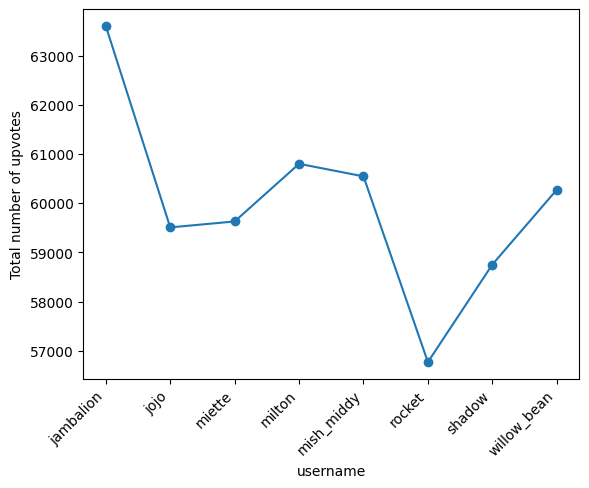

In [14]:
df = pd.DataFrame(response.json())
df = df.sort_values('username')

df.plot(x='username', y='total_upvotes', marker='o')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Total number of upvotes")
plt.gca().get_legend().remove()
plt.show()

The total number of upvotes likely depends on the total number of posts created per user. To better assess the relative impact per user, you compare the total number of upvotes (line plot) with the total number of posts.

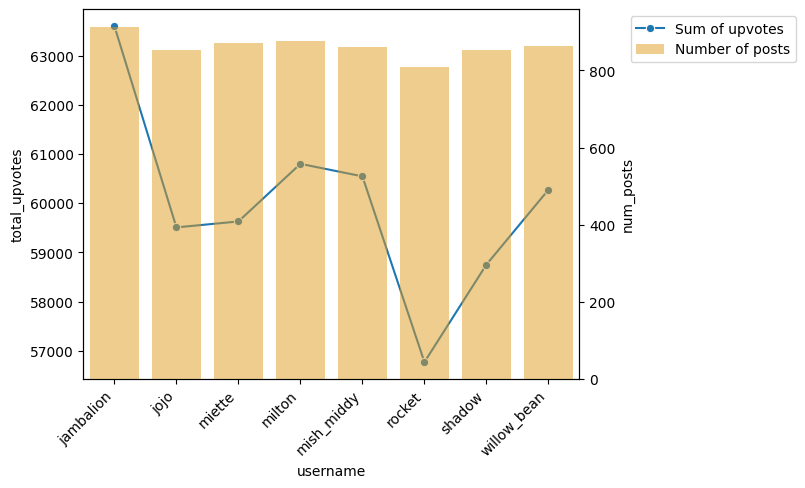

In [15]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots()
plt.xticks(rotation=45, ha='right')


sns.lineplot(data=df, x='username', y='total_upvotes', marker='o', ax=ax1, label="Sum of upvotes")
ax1.get_legend().remove()

ax2 = ax1.twinx()
sns.barplot(data = df, x='username', y='num_posts', order=df['username'], alpha=0.5, ax=ax2, color="orange", label = "Number of posts")


# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, bbox_to_anchor=(1.45, 1))

You should see a correlation between total number of upvotes and total number of posts. In order to track user impact on a more equal footing, normalize the total number of upvotes relative to the total number of posts, and plot the result:

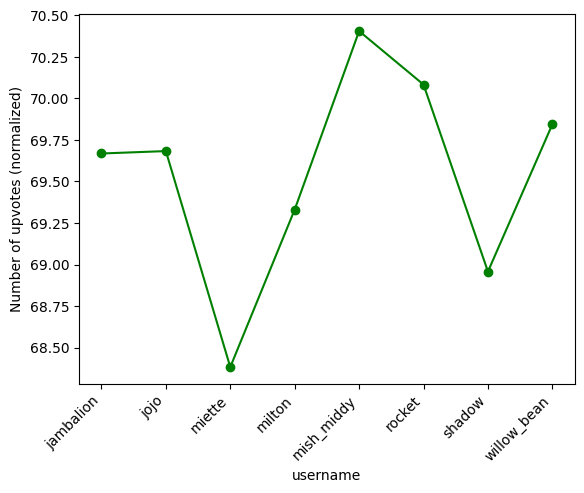

In [16]:
df['upvotes_normalized'] = df['total_upvotes']/df['num_posts']

df.plot(x='username', y='upvotes_normalized', marker='o', color='green')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of upvotes (normalized)")
plt.gca().get_legend().remove()
plt.show()

You've been working with data taken at a single snapshot in time from when you ran the last query. Run the query again, and store the output in `response2`, which you will compare with the previous results:

In [17]:
payload = json.dumps({
"query": "SELECT COUNT(post_title) as num_posts, SUM(upvotes) as total_upvotes, username FROM social_media GROUP BY username ORDER BY num_posts"
})

headers = {'Content-Type': 'application/json'}

response2 = requests.request(http_method, druid_host+query_endpoint, headers=headers, data=payload)
print(json.dumps(response2.json(), indent=2))

[
  {
    "num_posts": 1224,
    "total_upvotes": 84949,
    "username": "willow_bean"
  },
  {
    "num_posts": 1227,
    "total_upvotes": 85914,
    "username": "rocket"
  },
  {
    "num_posts": 1246,
    "total_upvotes": 86675,
    "username": "jojo"
  },
  {
    "num_posts": 1248,
    "total_upvotes": 85539,
    "username": "miette"
  },
  {
    "num_posts": 1282,
    "total_upvotes": 90171,
    "username": "mish_middy"
  },
  {
    "num_posts": 1289,
    "total_upvotes": 88261,
    "username": "shadow"
  },
  {
    "num_posts": 1316,
    "total_upvotes": 91601,
    "username": "jambalion"
  },
  {
    "num_posts": 1319,
    "total_upvotes": 91956,
    "username": "milton"
  }
]


Normalizing the data also helps you evaluate trends over time more consistently on the same plot axes. Plot the normalized data again, this time alongside the results from the previous snapshot:

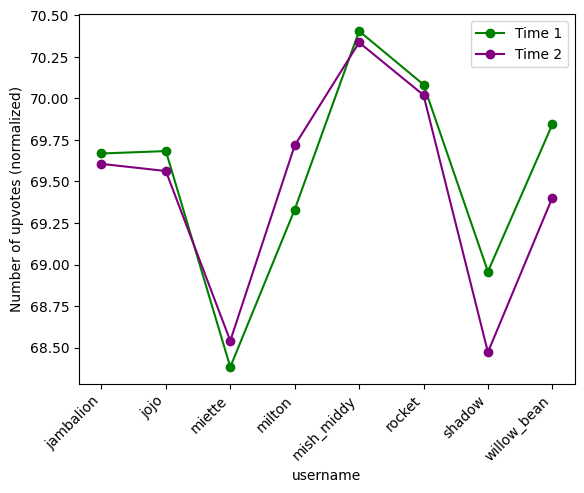

In [18]:
df2 = pd.DataFrame(response2.json())
df2 = df2.sort_values('username')
df2['upvotes_normalized'] = df2['total_upvotes']/df2['num_posts']

ax = df.plot(x='username', y='upvotes_normalized', marker='o', color='green', label="Time 1")
df2.plot(x='username', y='upvotes_normalized', marker='o', color='purple', ax=ax, label="Time 2")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of upvotes (normalized)")
plt.show()

This plot shows how some users maintain relatively consistent social media impact between the two query snapshots, whereas other users grow or decline in their influence.

## Learn more

This tutorial showed you how to create a Kafka topic using a Python client for Kafka, send a simulated stream of data to Kafka using a data generator, and query and visualize results over time. For more information, see the following resources:

* [Apache Kafka ingestion](https://druid.apache.org/docs/latest/development/extensions-core/kafka-ingestion.html)
* [Querying data](https://druid.apache.org/docs/latest/tutorials/tutorial-query.html)
* [Tutorial: Run with Docker](https://druid.apache.org/docs/latest/tutorials/docker.html)